In [1]:
import argparse
import json
import logging
import math
import os
import pickle
import random
import time
from datetime import datetime
from itertools import cycle
from tqdm import tqdm

import anndata
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ot
import torch
from datasets import load_from_disk
from torch.utils.data import Dataset, DataLoader
from scipy.sparse import issparse
from sklearn.metrics import pairwise
from sklearn.decomposition import PCA

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from scvi.model import SCVI

In [57]:
adata = sc.read_h5ad("/home/dfl32/project/ifm/cinemaot_data/raw_cinemaot.h5ad")
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=20)

hvgs = adata.var['highly_variable']

if issparse(adata.X):
    expression_data = adata.X.toarray()
else:
    expression_data = adata.X

# sample_indices = np.random.choice(expression_data.shape[0], size=5000, replace=False)
# expression_data = expression_data[sample_indices]

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [10]:
adata

AnnData object with n_obs × n_vars = 92125 × 21710
    obs: 'perturbation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', '_scvi_batch', '_scvi_labels'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'

In [53]:
# Load your pre-trained model
model = SCVI.load(
    dir_path="/home/dfl32/project/ifm/scvi_models/",
    prefix="epoch70_layers2_latent10_hidden128_pathsFalse",
    adata=adata)

# Number of samples to generate
n_samples = 10000  # Change this to the desired number of cells

# Latent space dimension
latent_dim = 10

# Sample from the standard Gaussian
z_samples = torch.randn(n_samples, latent_dim)

# Generate single-cell data
total_counts = adata.obs['total_counts']
median_counts = total_counts.median()
size_factors = total_counts / median_counts
library_sizes = torch.tensor(np.random.choice(size_factors, n_samples)).unsqueeze(1)

batch_index = torch.zeros(n_samples, dtype=torch.int64)
generated_data = model.module.generative(z=z_samples, batch_index=batch_index, library=library_sizes)

INFO     File /home/dfl32/project/ifm/scvi_models/epoch70_layers2_latent10_hidden128_pathsFalsemodel.pt already    
         downloaded                                                                                                


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.11 /home/dfl32/.conda/envs/c2s2/lib/python3.11/site ...
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [63]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

def compute_statistics(array1, array2):
    # Ensure the arrays have the same shape
    if array1.shape != array2.shape:
        raise ValueError("The input arrays must have the same shape.")
    
    # Calculate row-wise means
    mean1 = np.mean(array1, axis=0)
    mean2 = np.mean(array2, axis=0)
    
    # Calculate R^2
    correlation_matrix = np.corrcoef(mean1, mean2)
    r2 = correlation_matrix[0, 1] ** 2
    
    # Calculate Pearson correlation
    pearson_corr, _ = pearsonr(mean1, mean2)
    
    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(mean1, mean2)
    
    return r2, pearson_corr, spearman_corr

cells = generated_data['px'].sample().cpu().numpy()
sample_indices = np.random.choice(expression_data.shape[0], size=n_samples, replace=False)
sampled_expression_data = expression_data[sample_indices]

r2, pearson_corr, spearman_corr = compute_statistics(cells, sampled_expression_data)
print(f"R^2: {r2}")
print(f"Pearson correlation: {pearson_corr}")
print(f"Spearman correlation: {spearman_corr}")

r2, pearson_corr, spearman_corr = compute_statistics(cells[:, hvgs], sampled_expression_data[:, hvgs])
print(f"HVGS R^2: {r2}")
print(f"HVGS Pearson correlation: {pearson_corr}")
print(f"HVGS Spearman correlation: {spearman_corr}")

R^2: 0.9132695208624844
Pearson correlation: 0.9556513594729907
Spearman correlation: 0.7740956442764189
HVGS R^2: 0.7073216792306296
HVGS Pearson correlation: 0.8410241846883058
HVGS Spearman correlation: 0.3377689316780997


In [64]:
scvi_adata = anndata.AnnData(X=cells)
scvi_adata.obs['sample'] = ['cfm']*len(cells)
simple_sampled_adata = anndata.AnnData(X=expression_data)
simple_sampled_adata.obs['sample'] = ['train data']*len(simple_sampled_adata)
combined_adata = anndata.concat([simple_sampled_adata, scvi_adata])

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


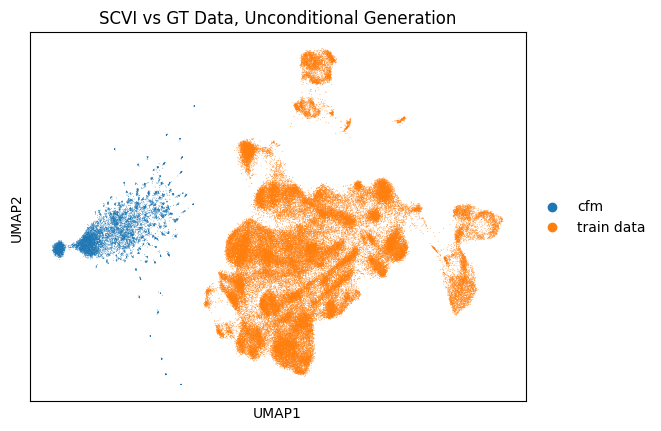

In [65]:
sc.pp.pca(combined_adata)
sc.pp.neighbors(combined_adata)
sc.tl.umap(combined_adata)
sc.pl.umap(combined_adata, color=['sample'], wspace=0.5, title="SCVI vs GT Data, Unconditional Generation")